https://www.kaggle.com/competitions/dog-breed-identification/data

## Load Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
from os.path import join

import PIL.Image
from PIL import ImageOps

import cv2

from tqdm import tqdm

In [3]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

## Load Image Data

In [4]:
# !unzip dog-breed-identification.zip

In [5]:
file_dir = './dog'

In [6]:
train_dir = f'{file_dir}/train'
test_dir = f'{file_dir}/test'

train_dir, test_dir

('./dog/train', './dog/test')

In [7]:
train_img_fpaths = [join(train_dir, f) for f in os.listdir(train_dir)]
test_img_fpaths = [join(test_dir, f) for f in os.listdir(test_dir)]

train_size = len(train_img_fpaths)
test_size = len(test_img_fpaths)

train_size, test_size

(10222, 10357)

In [8]:
# ais7 method
for root, dirs, files in os.walk("./dog"):
    print(root, dirs, len(files))

./dog ['test', 'train'] 3
./dog/test [] 10357
./dog/train [] 10222


In [9]:
df_train = pd.read_csv(f'{file_dir}/labels.csv')
df_train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
df_train.nunique()

id       10222
breed      120
dtype: int64

In [11]:
breeds_all = df_train['breed']


In [12]:
df_train.rename(columns={"breed": "label"}, inplace=True)
df_train["id"] = df_train["id"].apply(lambda x: x+".jpg")
df_train.head()

,id,label
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [13]:
test_files = os.listdir(test_dir)
df_test = pd.DataFrame({"id": test_files, 'label': 'golden_retriever'}) # empty label
df_test.head()

,id,label
0,266490a2b053a4a3bf68e779f28fb5a9.jpg,golden_retriever
1,dae9fd18836d8df20989ef0101771d4b.jpg,golden_retriever
2,079a40f22b0fad9a66f76797b62bb930.jpg,golden_retriever
3,ab8462f9a501d362041d47582fddc9ad.jpg,golden_retriever
4,8895089b432e020cc42e6262b5a1c2dd.jpg,golden_retriever


## AIS7

In [14]:
sample_label = df_train['label'].unique()[:5]
sample_label

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

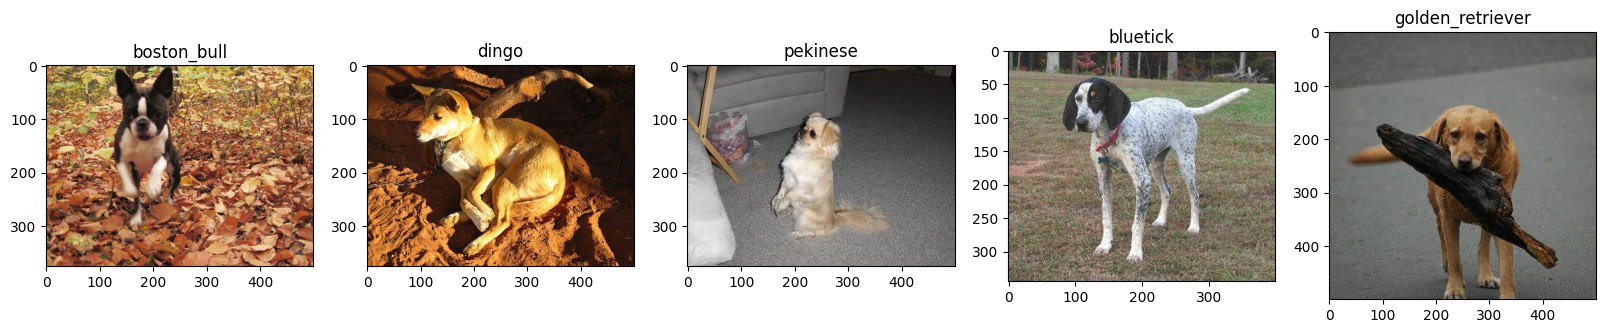

In [15]:
import glob

fig, axes = plt.subplots(nrows=1, ncols=int(len(sample_label)), figsize=(20, 10))

for i, img_label in enumerate(sample_label):
    img_id = df_train.loc[df_train.label == img_label,['id']].reset_index(drop=True)
    wfiles = glob.glob(f"./dog/train/{img_id.iloc[0]['id']}")
    img = plt.imread(wfiles[0])
    axes[i].imshow(img)
    axes[i].set_title(img_label)

## Data Generator

In [16]:
data_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [17]:
width = 299
height = 299

In [18]:
train_gen = data_gen.flow_from_dataframe(df_train, train_dir, x_col='id', y_col='label',
                                          color_mode = 'rgb',
                                          target_size = (height, width),
                                          class_mode = 'categorical',
                                          batch_size = 128,
                                          subset ='training',
                                          shuffle = True,
                                          seed = 123)

Found 8178 validated image filenames belonging to 120 classes.


In [19]:
val_gen = data_gen.flow_from_dataframe(df_train, train_dir, x_col='id', y_col='label',
                                          color_mode = 'rgb',
                                          target_size = (height, width),
                                          class_mode = 'categorical',
                                          batch_size = 128,
                                          subset ='validation',
                                          shuffle = True,
                                          seed = 123)

Found 2044 validated image filenames belonging to 120 classes.


## Image Pre-processing

In [20]:
def image_preprocessing(path):
    image = PIL.Image.open(path)
    size = (height,width)
    image = ImageOps.fit(image, size, PIL.Image.ANTIALIAS)
    image_array = np.asarray(image)
    return image_array

In [21]:
df_train_with_path = df_train.copy()

df_train_with_path['img_path'] = train_dir + '/' + df_train_with_path['id']

df_train_with_path

,id,label,img_path
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,./dog/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,./dog/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese,./dog/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,./dog/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,./dog/train/0021f9ceb3235effd7fcde7f7538ed62.jpg
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0.jpg,borzoi,./dog/train/ffd25009d635cfd16e793503ac5edef0.jpg
10218,ffd3f636f7f379c51ba3648a9ff8254f.jpg,dandie_dinmont,./dog/train/ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f.jpg,airedale,./dog/train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220,ffe5f6d8e2bff356e9482a80a6e29aac.jpg,miniature_pinscher,./dog/train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg


In [22]:
dogs = []
label_names = []

for i in range(0, len(df_train_with_path)):
    label = df_train_with_path.iloc[i,1]
    filename = df_train_with_path.iloc[i,2]
    image = image_preprocessing(filename)
    dogs.append(image)
    label_names.append(label)

print(np.shape(label_names))
print(np.shape(dogs))

/var/folders/h_/lxrkd3yx3w11tnfvg06j7l140000gn/T/ipykernel_62511/1747162994.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = ImageOps.fit(image, size, PIL.Image.ANTIALIAS)


(10222,)
(10222, 299, 299, 3)


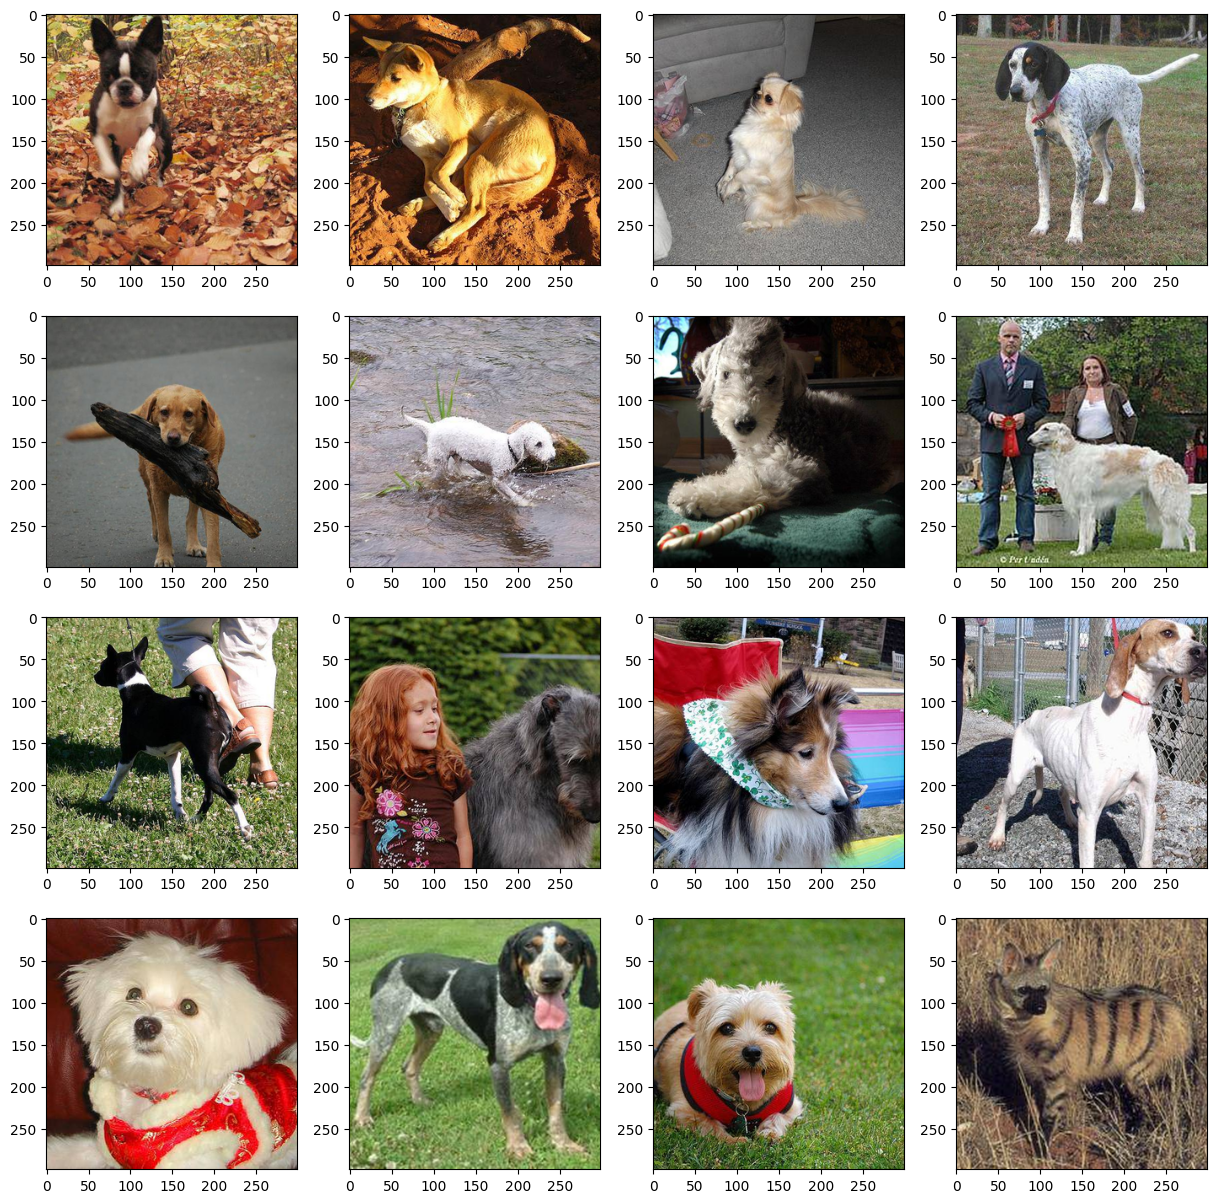

In [23]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = dogs
    plt.imshow(image[i])
plt.show()

## CNN

In [24]:
# model = Sequential()

# model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid',
#                  activation='relu', input_shape=(height, width, 3)))

# model.add(MaxPooling2D(pool_size=(2,2), strides=1))

# model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
#                  activation='relu'))

# model.add(MaxPooling2D(pool_size=(2,2), strides=1))

# model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same',
#                  activation='relu'))

# model.add(Flatten())
# model.add(Dense(units=40, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(units=20, activation="relu"))
# model.add(Dropout(0.2))

# model.add(Dense(len(list(train_gen.class_indices.keys())), activation='softmax'))

# model.summary()

In [25]:
# model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = 'accuracy')

In [26]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
]

In [27]:
# history = model.fit(train_gen,
#                     epochs = 20,
#                     callbacks = callbacks,
#                     validation_data = val_gen)

In [28]:
# df_hist = pd.DataFrame(history.history)
# df_hist.tail()

In [29]:
# figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
# df_hist[['loss', 'val_loss']].plot(ax=axes[0])
# df_hist[['accuracy','val_accuracy']].plot(ax=axes[1])

## Transfer Learning

In [30]:
# train_gen = data_gen.flow_from_dataframe(df_train, train_dir, x_col='id', y_col='label',
#                                           color_mode = 'rgb',
#                                           target_size = (height, width),
#                                           class_mode = 'categorical',
#                                           batch_size = 128,
#                                           subset ='training',
#                                           shuffle = True,
#                                           seed = 123)

# val_gen = data_gen.flow_from_dataframe(df_train, train_dir, x_col='id', y_col='label',
#                                           color_mode = 'rgb',
#                                           target_size = (height, width),
#                                           class_mode = 'categorical',
#                                           batch_size = 128,
#                                           subset ='validation',
#                                           shuffle = True,
#                                           seed = 123)

In [31]:
base_model = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = ((height, width, 3)))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
predictions = Dense(len(list(train_gen.class_indices.keys())), activation = 'softmax',
                    kernel_initializer = 'random_uniform')(x)

model = Model(inputs = base_model.input, outputs = predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer= Adam(), loss = 'categorical_crossentropy', metrics = 'accuracy')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-12 02:55:24.762724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 02:55:24.762898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
history = model.fit(train_gen,
                    epochs = 50,
                    callbacks = callbacks,
                    validation_data = val_gen)

Epoch 1/50


2022-12-12 02:55:29.232805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 02:55:33.715900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.7563

2022-12-12 02:57:40.468583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 164s 2s/step - loss: 1.0961 - accuracy: 0.7563 - val_loss: 0.5711 - val_accuracy: 0.8567
Epoch 2/50
64/64 [==============================] - 156s 2s/step - loss: 0.2179 - accuracy: 0.9325 - val_loss: 0.6143 - val_accuracy: 0.8625
Epoch 3/50
64/64 [==============================] - 156s 2s/step - loss: 0.1107 - accuracy: 0.9638 - val_loss: 0.6285 - val_accuracy: 0.8601
Epoch 4/50
64/64 [==============================] - 161s 3s/step - loss: 0.0685 - accuracy: 0.9790 - val_loss: 0.6298 - val_accuracy: 0.8650
Epoch 5/50
64/64 [==============================] - 156s 2s/step - loss: 0.0457 - accuracy: 0.9870 - val_loss: 0.6689 - val_accuracy: 0.8752
Epoch 6/50
64/64 [==============================] - 158s 2s/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.6097 - val_accuracy: 0.8816


In [33]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
1,0.217907,0.932502,0.614280,0.862524
2,0.110685,0.963805,0.628466,0.860078
3,0.068508,0.978968,0.629841,0.864971
4,0.045732,0.987038,0.668932,0.875245
5,0.029038,0.991685,0.609718,0.881605


<AxesSubplot: >

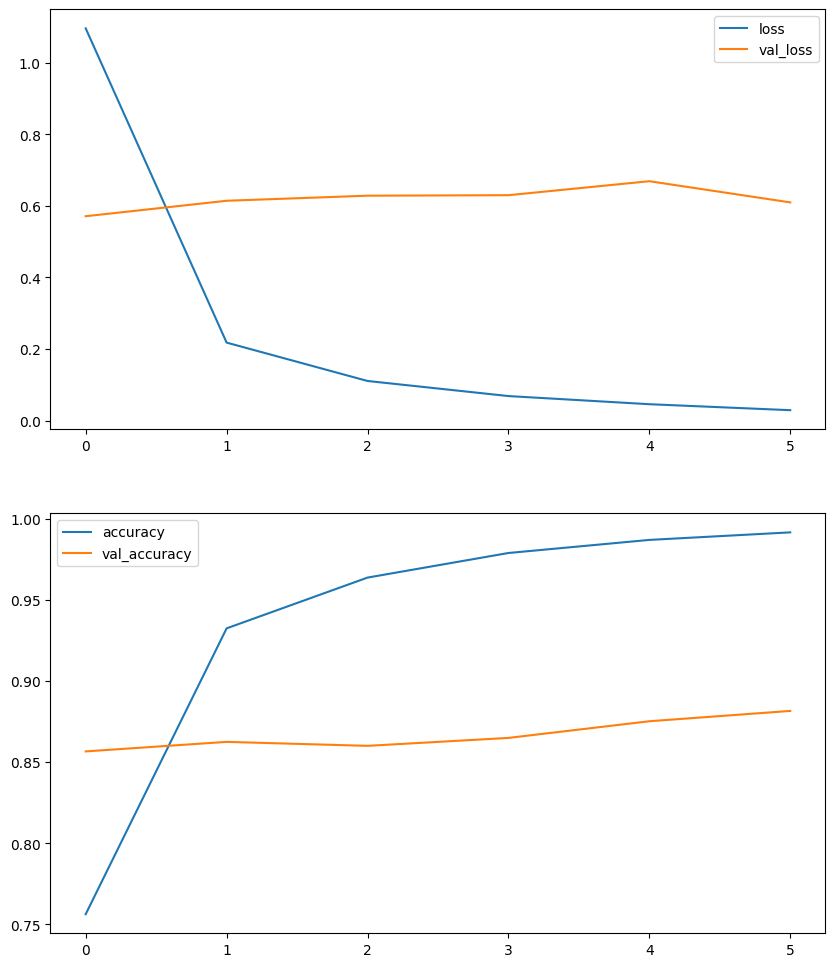

In [34]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
df_hist[['loss', 'val_loss']].plot(ax=axes[0])
df_hist[['accuracy','val_accuracy']].plot(ax=axes[1])

In [35]:
test_data_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_data_gen.flow_from_dataframe(df_test, test_dir, x_col = 'id', y_col = 'label', color_mode = 'rgb',
                                                   class_mode = 'categorical', target_size = (299, 299), batch_size = 32, shuffle = False,
                                                   seed = 123)

Found 10357 validated image filenames belonging to 1 classes.


In [36]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/var/folders/h_/lxrkd3yx3w11tnfvg06j7l140000gn/T/ipykernel_62511/4054959399.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


Test loss: 2323.743896484375
Test accuracy: 0.007531138602644205


In [37]:
label_map = (train_gen.class_indices)
label_map_inv = {v: k for k, v in label_map.items()}

In [38]:
ypreds = model.predict_generator(generator = test_generator, steps = len(test_generator), verbose = 1)
ypreds

/var/folders/h_/lxrkd3yx3w11tnfvg06j7l140000gn/T/ipykernel_62511/3228931230.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ypreds = model.predict_generator(generator = test_generator, steps = len(test_generator), verbose = 1)
2022-12-12 03:14:01.394952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


324/324 [==============================] - 165s 491ms/step


array([[1.15355236e-09, 5.19041893e-11, 1.25336295e-14, ...,
        1.73275339e-10, 1.01076130e-13, 3.32807566e-13],
       [6.78337924e-03, 8.05470464e-08, 6.78667107e-07, ...,
        2.52122787e-04, 1.72112152e-04, 2.48669767e-06],
       [4.19366930e-10, 3.34951942e-08, 3.23774785e-08, ...,
        4.99222842e-13, 5.72070212e-12, 8.08530021e-10],
       ...,
       [1.04940831e-07, 4.24891113e-07, 8.47851034e-09, ...,
        1.45669974e-08, 1.14152160e-11, 4.42525172e-09],
       [4.26066492e-07, 6.73680643e-12, 4.24947588e-09, ...,
        8.37254902e-07, 4.99119288e-11, 2.89337221e-09],
       [2.87524301e-07, 9.12435613e-11, 2.51440298e-07, ...,
        7.78379899e-07, 2.06176374e-08, 1.91621261e-08]], dtype=float32)

In [39]:
ypred = ypreds.argmax(axis = -1)
ypred

array([12, 59, 78, ...,  8, 72, 97])

In [40]:
submission = pd.read_csv('./dog/sample_submission.csv')
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [41]:
test_dir_files = os.listdir(test_dir)
test_gen_files = test_generator.filenames
submission_files = submission["id"]
len(submission_files)

10357

In [42]:
submission_files

0        000621fb3cbb32d8935728e48679680e
1        00102ee9d8eb90812350685311fe5890
2        0012a730dfa437f5f3613fb75efcd4ce
3        001510bc8570bbeee98c8d80c8a95ec1
4        001a5f3114548acdefa3d4da05474c2e
                       ...               
10352    ffeda8623d4eee33c6d1156a2ecbfcf8
10353    fff1ec9e6e413275984966f745a313b0
10354    fff74b59b758bbbf13a5793182a9bbe4
10355    fff7d50d848e8014ac1e9172dc6762a3
10356    fffbff22c1f51e3dc80c4bf04089545b
Name: id, Length: 10357, dtype: object

In [43]:
m = {}
l = len(test_gen_files)
for i in range(l):
    m[test_gen_files[i]] = ypreds[i] 

In [44]:
labels = (train_gen.class_indices)
labels = list(labels.keys())

In [45]:
ypreds_sync = []
for f in submission_files:
    ypreds_sync.append(m[f+".jpg"])

In [46]:
test_df = pd.DataFrame(data = ypreds_sync, columns = labels)
test_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,4.543091e-12,7.215729e-11,2.051580e-10,2.180687e-12,4.102120e-14,1.308368e-14,6.881280e-12,2.271984e-14,1.021576e-14,8.537284e-14,...,1.303087e-11,5.045474e-11,5.011662e-11,1.282173e-11,4.373078e-13,1.560599e-15,1.304761e-10,1.257037e-11,2.553818e-11,1.947720e-08
1,1.398999e-06,2.533555e-06,4.987909e-07,4.113223e-07,1.958743e-08,1.627422e-06,1.168483e-06,2.192455e-05,9.556843e-09,6.445094e-09,...,2.046822e-09,1.004574e-04,1.554942e-07,4.550963e-07,6.921449e-06,1.417410e-06,3.695726e-06,2.019244e-05,3.235614e-07,1.457279e-05
2,5.131347e-10,2.479898e-10,3.790161e-11,5.954472e-11,1.315123e-13,3.263979e-10,1.111230e-10,7.844257e-13,2.900676e-09,7.279295e-09,...,1.915365e-10,4.980138e-09,2.760866e-10,7.835445e-09,3.649811e-12,1.259304e-10,2.124145e-11,1.281913e-09,5.625229e-11,4.779582e-11
3,4.350011e-03,1.240722e-09,2.912830e-10,1.401977e-10,3.181121e-16,2.354896e-05,1.081109e-07,7.631318e-06,4.181167e-08,2.114458e-08,...,6.099689e-06,1.250054e-06,1.092232e-10,3.941265e-09,1.051549e-10,1.286108e-09,5.577100e-09,3.431840e-09,9.922707e-10,2.586378e-06
4,5.991187e-03,4.977451e-10,3.504736e-09,2.801484e-10,6.003589e-08,1.832021e-07,1.266395e-09,1.336950e-07,5.289048e-11,1.329958e-07,...,1.034886e-08,7.797281e-07,6.418203e-08,4.314514e-07,3.071165e-07,1.348904e-12,5.986447e-10,4.379165e-09,4.011329e-07,6.596527e-07


In [47]:
test_df["id"] = submission_files

cols = test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
test_df = test_df[cols]
test_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,4.543091e-12,7.215729e-11,2.051580e-10,2.180687e-12,4.102120e-14,1.308368e-14,6.881280e-12,2.271984e-14,1.021576e-14,...,1.303087e-11,5.045474e-11,5.011662e-11,1.282173e-11,4.373078e-13,1.560599e-15,1.304761e-10,1.257037e-11,2.553818e-11,1.947720e-08
1,00102ee9d8eb90812350685311fe5890,1.398999e-06,2.533555e-06,4.987909e-07,4.113223e-07,1.958743e-08,1.627422e-06,1.168483e-06,2.192455e-05,9.556843e-09,...,2.046822e-09,1.004574e-04,1.554942e-07,4.550963e-07,6.921449e-06,1.417410e-06,3.695726e-06,2.019244e-05,3.235614e-07,1.457279e-05
2,0012a730dfa437f5f3613fb75efcd4ce,5.131347e-10,2.479898e-10,3.790161e-11,5.954472e-11,1.315123e-13,3.263979e-10,1.111230e-10,7.844257e-13,2.900676e-09,...,1.915365e-10,4.980138e-09,2.760866e-10,7.835445e-09,3.649811e-12,1.259304e-10,2.124145e-11,1.281913e-09,5.625229e-11,4.779582e-11
3,001510bc8570bbeee98c8d80c8a95ec1,4.350011e-03,1.240722e-09,2.912830e-10,1.401977e-10,3.181121e-16,2.354896e-05,1.081109e-07,7.631318e-06,4.181167e-08,...,6.099689e-06,1.250054e-06,1.092232e-10,3.941265e-09,1.051549e-10,1.286108e-09,5.577100e-09,3.431840e-09,9.922707e-10,2.586378e-06
4,001a5f3114548acdefa3d4da05474c2e,5.991187e-03,4.977451e-10,3.504736e-09,2.801484e-10,6.003589e-08,1.832021e-07,1.266395e-09,1.336950e-07,5.289048e-11,...,1.034886e-08,7.797281e-07,6.418203e-08,4.314514e-07,3.071165e-07,1.348904e-12,5.986447e-10,4.379165e-09,4.011329e-07,6.596527e-07


In [ ]:
test_df.to_csv('./dog/submission.csv', index=False)